In [15]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from conf_dict_util import conf_to_dict, dict_to_conf
from qoe_utils import make_bandwidth_series, get_QoE_rr, get_QoE_delay, get_QoE_losses, get_reward

In [16]:
traces = [
'WIRED_200kbps',
'WIRED_900kbps',
'WIRED_35mbps',
'4G_500kbps',
'4G_700kbps',
'4G_3mbps',
'5G_12mbps',
'5G_13mbps',
'trace_300k'
]

In [42]:
from matplotlib import rcParams
#IEEE Times New Roman (Nimbus Roman)
rcParams['text.latex.preamble'] = r"\usepackage{mathptmx}"

#Latex in general
rcParams['font.family'] = "serif"
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

In [18]:
from best_algs import best_models_dict
list_conf_names = [d[200] for d in best_models_dict.values()]
print("Len list_conf_names: ", len(list_conf_names))

Len list_conf_names:  9


In [25]:
list_conf_names = [
 'TD3_WIRED_200kbps_200_delay_False_norm_states_True_tuned_False_reward_profile_0_seed_22',
'SAC_WIRED_900kbps_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22',
 'TD3_WIRED_35mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22',
    
'TD3_4G_500kbps_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22',
 'TD3_4G_700kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22',
 'SAC_4G_3mbps_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22',
 
 'TD3_5G_12mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22',
 'TD3_5G_13mbps_200_delay_False_norm_states_True_tuned_False_reward_profile_0_seed_22',
 'TD3_trace_300k_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22'
]

In [ ]:
trace_dict = {
'WIRED_900kbps': "Wired 900kbps",
 'WIRED_200kbps': "Wired 200kbps",
 'WIRED_35mbps': "Wired 35Mbps",
 '4G_700kbps': "4G 700kbps",
 '4G_3mbps': "4G 3Mbps",
 '4G_500kbps': "4G 500kbps",
 '5G_12mbps': "5G 12Mbps",
 '5G_13mbps': "5G 13Mbps",
 'trace_300k': "300kbps"
}

In [61]:
plot_rr = False
plot_delay = False

prefix = "../output/rates_delay_loss_test_"
suffix = ".pickle"
result_qoe = []


for conf_name in list_conf_names:
    
    d = conf_to_dict(conf_name)
    
    # print("Input model: ", conf_name, " trained on trace: ", d["trace_name"])

    time_step = d["step_time"]
    reward_profile = d["reward_profile"]
    delay_states = d["delay_states"]
    normalize_states = d["normalize_states"]
    alg_name = d["alg"]

    name = d["trace_name"]

    #Read rates_delay_loss and make l_rate
    pickle_path = prefix+conf_name+suffix
    if not os.path.exists(pickle_path):
        print("Conf doesn't exist: ", conf_name)
        print("--------------------------")
        continue
    
    dict_result = {}
    dict_result["trained_on_trace"] = trace_dict[d["trace_name"]]
    
    l_rate = pd.read_pickle(pickle_path)
    
    for trace in traces:
        
        trace_fancy = trace_dict[trace]
        dict_result[trace_fancy] = {}
    
        #Read the same for GCC
        pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{trace}.pickle"
        l_rate_gcc = pd.read_pickle(pickle_path_gcc)
        trace_name = l_rate_gcc["trace_name"]
        if trace_name != trace:
            print("Does not coincide with GCC pickle!")
        
    
        #QoE rr
        U, U_gcc = get_QoE_rr(l_rate, l_rate_gcc, trace, time_step, test=True)
        qoe_rr = 100*U.quantile(0.5)
        qoe_rr_gcc = 100*U_gcc.quantile(0.5)
        # print("QoE rr:", f"RL: {round(qoe_rr,2)}, GCC: {round(qoe_rr_gcc,2)}")
        if plot_rr:
            plot_cdf_multiple([U, U_gcc], "bandwidth_util", legend=["RL", "GCC"], figsize=(4,2))
            plt.show()

        dict_result[trace_fancy]["qoe_rr"] = qoe_rr
        # dict_result[trace]["qoe_rr_gcc"] = qoe_rr_gcc

        #QoE delay
        delay, delay_gcc, qoe_delay, qoe_delay_gcc = get_QoE_delay(l_rate, l_rate_gcc, trace, time_step, test=True)
        # print("QoE delay:", f"RL: {round(qoe_delay,2)}, GCC: {round(qoe_delay_gcc,2)}")
        if plot_delay:
            plot_cdf_multiple([delay, delay_gcc], "delay", legend=["RL", "GCC"], figsize=(4,2))
            plt.xlim(0,1000)
            plt.show()

        dict_result[trace_fancy]["qoe_delay"] = qoe_delay
        # dict_result[trace]["qoe_delay_gcc"] = qoe_delay_gcc

        #QoE losses
        loss_ratio, loss_ratio_gcc, qoe_losses, qoe_losses_gcc = get_QoE_losses(l_rate, l_rate_gcc, trace, time_step, test=True)
        # print("QoE loss:", f"RL: {round(qoe_losses,2)}, GCC: {round(qoe_losses_gcc,2)}")

        dict_result[trace_fancy]["qoe_losses"] = round(qoe_losses,2)
        # dict_result[trace]["qoe_losses_gcc"] = round(qoe_losses_gcc,2)

        #Overall QoE
        qoe = 0.333*qoe_rr + 0.333*qoe_delay + 0.333*qoe_losses
        qoe_gcc = 0.333*qoe_rr_gcc + 0.333*qoe_delay_gcc + 0.333*qoe_losses_gcc

        dict_result[trace_fancy]["qoe"] = qoe
        # dict_result[trace]["qoe_gcc"] = qoe_gcc

        # print(f"Overall QoE for trained on {name}, tested on {trace}:", f"RL: {round(qoe,2)}, GCC: {round(qoe_gcc,2)}")
        # print("---------")
        
        cum_reward, avg_reward = get_reward(l_rate, trace, test=True)

        dict_result[trace_fancy]["cum_reward"] = cum_reward
        dict_result[trace_fancy]["avg_reward"] = avg_reward

    result_qoe.append(dict_result)

In [62]:
df = pd.DataFrame(result_qoe).set_index("trained_on_trace")
df

,Wired 200kbps,Wired 900kbps,Wired 35Mbps,4G 500kbps,4G 700kbps,4G 3Mbps,5G 12Mbps,5G 13Mbps,300kbps
trained_on_trace,,,,,,,,,
Wired 200kbps,"{'qoe_rr': 85.6045197740113, 'qoe_delay': 98.0...","{'qoe_rr': 21.882903981264636, 'qoe_delay': 26...","{'qoe_rr': 0.5801183431952663, 'qoe_delay': 63...","{'qoe_rr': 36.340371081254, 'qoe_delay': 92.53...","{'qoe_rr': 28.949669439112814, 'qoe_delay': 92...","{'qoe_rr': 7.576865671641792, 'qoe_delay': 93....","{'qoe_rr': 1.513125, 'qoe_delay': 51.134967736...","{'qoe_rr': 1.4550659668038022, 'qoe_delay': 49...","{'qoe_rr': 56.080000000000005, 'qoe_delay': 0...."
Wired 900kbps,"{'qoe_rr': 100.0, 'qoe_delay': 49.286443293836...","{'qoe_rr': 75.88193624557262, 'qoe_delay': 83....","{'qoe_rr': 1.9931563421828908, 'qoe_delay': 73...","{'qoe_rr': 99.62678609511624, 'qoe_delay': 48....","{'qoe_rr': 92.4896648457109, 'qoe_delay': 78.2...","{'qoe_rr': 43.43589743589744, 'qoe_delay': 84....","{'qoe_rr': 5.136608743369306, 'qoe_delay': 75....","{'qoe_rr': 5.252540952380952, 'qoe_delay': 44....","{'qoe_rr': 100.0, 'qoe_delay': 0.4910988336402..."
Wired 35Mbps,"{'qoe_rr': 100.0, 'qoe_delay': 47.741139302991...","{'qoe_rr': 98.51288343558282, 'qoe_delay': 10....","{'qoe_rr': 20.522474226804125, 'qoe_delay': 66...","{'qoe_rr': 100.0, 'qoe_delay': 12.650770721499...","{'qoe_rr': 100.0, 'qoe_delay': 14.614381775765...","{'qoe_rr': 99.23875, 'qoe_delay': 37.510074282...","{'qoe_rr': 50.66151898734177, 'qoe_delay': 72....","{'qoe_rr': 41.717666250668564, 'qoe_delay': 38...","{'qoe_rr': 100.0, 'qoe_delay': 0.0659811953593..."
4G 500kbps,"{'qoe_rr': 86.37037037037038, 'qoe_delay': 86....","{'qoe_rr': 50.74418604651163, 'qoe_delay': 95....","{'qoe_rr': 1.3175366568914957, 'qoe_delay': 69...","{'qoe_rr': 69.98080614203455, 'qoe_delay': 91....","{'qoe_rr': 58.850220560999425, 'qoe_delay': 95...","{'qoe_rr': 15.661194029850748, 'qoe_delay': 88...","{'qoe_rr': 3.2122044453989043, 'qoe_delay': 60...","{'qoe_rr': 3.0983107672469377, 'qoe_delay': 58...","{'qoe_rr': 90.68, 'qoe_delay': 90.627495185759..."
4G 700kbps,"{'qoe_rr': 95.86666666666666, 'qoe_delay': 93....","{'qoe_rr': 82.3177570093458, 'qoe_delay': 63.1...","{'qoe_rr': 3.2630088495575222, 'qoe_delay': 71...","{'qoe_rr': 78.21497120921305, 'qoe_delay': 88....","{'qoe_rr': 72.79643847302198, 'qoe_delay': 86....","{'qoe_rr': 18.517777777777777, 'qoe_delay': 84...","{'qoe_rr': 7.269772632457238, 'qoe_delay': 61....","{'qoe_rr': 7.149379684673043, 'qoe_delay': 47....","{'qoe_rr': 74.41333333333333, 'qoe_delay': 18...."
4G 3Mbps,"{'qoe_rr': 16.615384615384617, 'qoe_delay': 99...","{'qoe_rr': 3.549295774647887, 'qoe_delay': 67....","{'qoe_rr': 1.643478260869565, 'qoe_delay': 49....","{'qoe_rr': 6.5111472021260886, 'qoe_delay': 95...","{'qoe_rr': 4.5345489443378115, 'qoe_delay': 94...","{'qoe_rr': 81.9125, 'qoe_delay': 91.0652554341...","{'qoe_rr': 0.24387096774193548, 'qoe_delay': 4...","{'qoe_rr': 19.579428244711263, 'qoe_delay': 43...","{'qoe_rr': 10.08, 'qoe_delay': 80.0, 'qoe_loss..."
5G 12Mbps,"{'qoe_rr': 100.0, 'qoe_delay': 47.461925629147...","{'qoe_rr': 98.52927400468384, 'qoe_delay': 5.3...","{'qoe_rr': 22.224000000000004, 'qoe_delay': 72...","{'qoe_rr': 99.2654658201683, 'qoe_delay': 47.9...","{'qoe_rr': 98.27624390964121, 'qoe_delay': 63....","{'qoe_rr': 100.0, 'qoe_delay': 87.661606706209...","{'qoe_rr': 55.947957009433516, 'qoe_delay': 72...","{'qoe_rr': 50.49937106918239, 'qoe_delay': 54....","{'qoe_rr': 100.0, 'qoe_delay': 0.5608229104487..."
5G 13Mbps,"{'qoe_rr': 100.0, 'qoe_delay': 47.453772704194...","{'qoe_rr': 98.39755351681957, 'qoe_delay': 8.6...","{'qoe_rr': 16.31693215339233, 'qoe_delay': 67....","{'qoe_rr': 99.88603646833013, 'qoe_delay': 12....","{'qoe_rr': 99.12151188542744, 'qoe_delay': 15....","{'qoe_rr': 97.915, 'qoe_delay': 89.44179716200...","{'qoe_rr': 40.889192690261396, 'qoe_delay': 68...","{'qoe_rr': 40.53868844296171, 'qoe_delay': 61....","{'qoe_rr': 100.0, 'qoe_delay': 0.1989829759009..."
300kbps,"{'qoe_rr': 98.22222222222223

In [63]:
df = pd.DataFrame(result_qoe).set_index("trained_on_trace")
df = df[df.index]
df_qoe = df.applymap(lambda x: x["qoe"])
df_qoe_rr = df.applymap(lambda x: x["qoe_rr"])
df_qoe_delay = df.applymap(lambda x: x["qoe_delay"])
df_qoe_loss = df.applymap(lambda x: x["qoe_losses"])
df_avg_reward = df.applymap(lambda x: x["avg_reward"])
df_cum_reward = df.applymap(lambda x: x["cum_reward"])

In [64]:
# df_avg_reward = df_avg_reward.rename(columns=trace_dict)
# df_avg_reward.index = df_avg_reward.columns

In [65]:
df_avg_reward

,Wired 200kbps,Wired 900kbps,Wired 35Mbps,4G 500kbps,4G 700kbps,4G 3Mbps,5G 12Mbps,5G 13Mbps,300kbps
trained_on_trace,,,,,,,,,
Wired 200kbps,0.275064,0.048637,-0.080623,0.107334,0.086961,-0.336612,-0.183520,-0.225397,0.221143
Wired 900kbps,-0.987255,0.442057,-0.066353,-0.896855,-0.205121,-0.361109,-0.199423,-0.207023,-0.927220
Wired 35Mbps,-0.989690,-0.943270,-0.007698,-0.959486,-0.956197,-0.791565,-0.153325,-0.162963,-0.962931
4G 500kbps,-0.115302,0.220097,-0.070309,0.066000,0.130279,-0.315359,-0.176932,-0.214478,-0.002408
4G 700kbps,-0.181253,0.507858,-0.047887,0.117394,0.153140,-0.352393,-0.181257,-0.205139,0.127367
4G 3Mbps,-0.005300,-0.049667,-0.045488,-0.023087,-0.038078,-0.448433,-0.152155,-0.192104,-0.017754
5G 12Mbps,-0.996667,-0.798075,-0.024025,-0.928355,-0.855837,-0.779088,-0.091321,-0.157564,-0.988174
5G 13Mbps,-0.998267,-0.975776,-0.026359,-0.952354,-0.953709,-0.601280,-0.083862,-0.142135,-0.993497
300kbps,-0.271022,0.094492,-0.079353,0.081806,0.111605,-0.336046,-0.182967,-0.221822,0.503375


In [67]:
fontsize=12
figsize=(7,5)
ticks_fontsize = 10

In [69]:
# plt.figure(figsize=figsize)
# ax = sns.heatmap(df_avg_reward ,cmap="RdYlGn", vmin=-1, vmax=1, annot=True, fmt=".2f")
# plt.ylabel("Training trace", fontsize=fontsize)
# plt.xlabel("Testing trace", fontsize=fontsize)
# a=plt.xticks(fontsize=ticks_fontsize)
# b=plt.yticks(fontsize=ticks_fontsize)
# a = plt.title("Average reward")

### Overall QoE

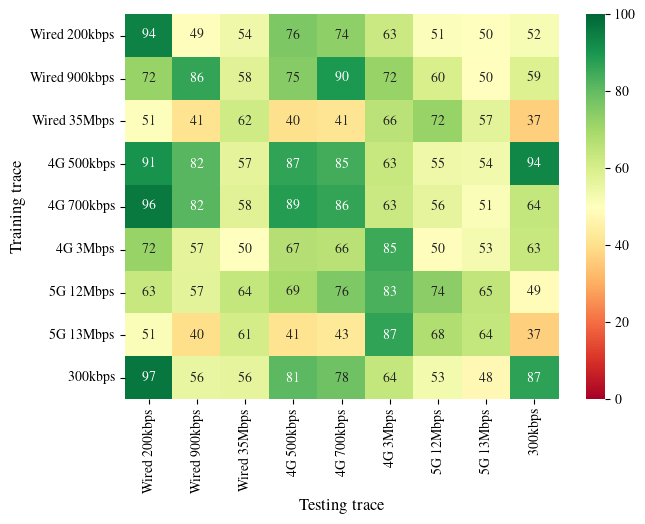

In [70]:
plt.figure(figsize=figsize)
ax = sns.heatmap(df_qoe ,cmap="RdYlGn", vmin=0, vmax=100, annot=True)
plt.ylabel("Training trace", fontsize=fontsize)
plt.xlabel("Testing trace", fontsize=fontsize)
a=plt.xticks(fontsize=ticks_fontsize)
b=plt.yticks(fontsize=ticks_fontsize)

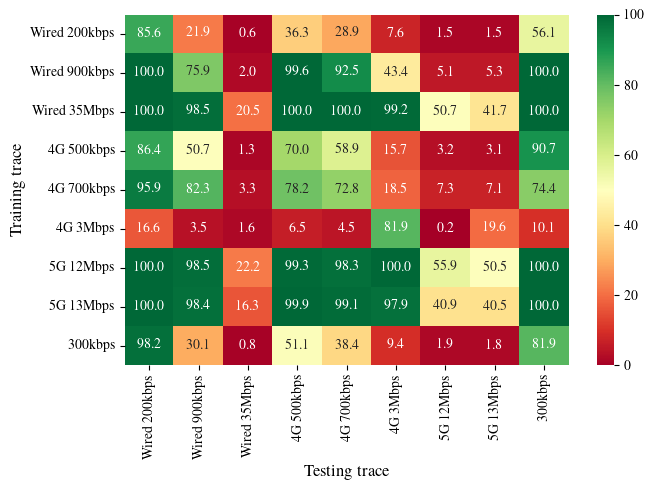

In [77]:
plt.figure(figsize=figsize)
ax = sns.heatmap(df_qoe_rr ,cmap="RdYlGn", vmin=0, vmax=100, annot=True, fmt=".1f")
# a = plt.title("QoE receiving rate (bandwidth utilization)")
plt.ylabel("Training trace", fontsize=fontsize)
plt.xlabel("Testing trace", fontsize=fontsize)
a=plt.xticks(fontsize=ticks_fontsize)
b=plt.yticks(fontsize=ticks_fontsize)
plt.tight_layout()
plt.savefig("plots/cross_qoe_rr.pdf")

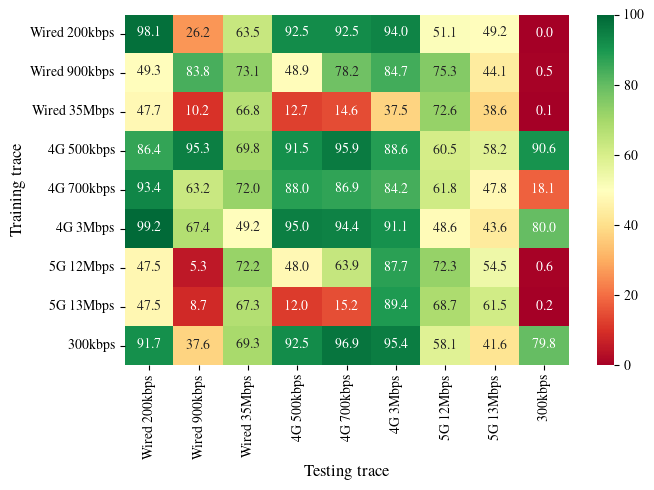

In [78]:
plt.figure(figsize=figsize)
ax = sns.heatmap(df_qoe_delay ,cmap="RdYlGn", vmin=0, vmax=100, annot=True, fmt=".1f")
# a = plt.title("QoE delay")
plt.ylabel("Training trace", fontsize=fontsize)
plt.xlabel("Testing trace", fontsize=fontsize)
a=plt.xticks(fontsize=ticks_fontsize)
b=plt.yticks(fontsize=ticks_fontsize)
plt.tight_layout()
plt.savefig("plots/cross_qoe_delay.pdf")

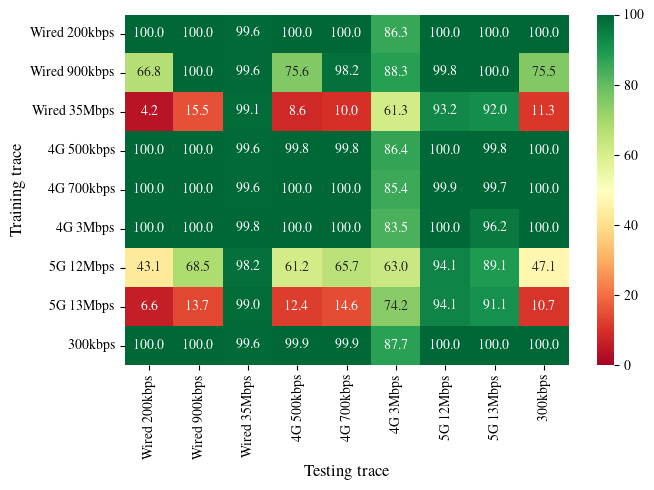

In [79]:
plt.figure(figsize=figsize)
ax = sns.heatmap(df_qoe_loss ,cmap="RdYlGn", vmin=0, vmax=100, annot=True, fmt=".1f")
# a = plt.title("QoE losses")
plt.ylabel("Training trace", fontsize=fontsize)
plt.xlabel("Testing trace", fontsize=fontsize)
a=plt.xticks(fontsize=ticks_fontsize)
b=plt.yticks(fontsize=ticks_fontsize)
plt.tight_layout()
plt.savefig("plots/cross_qoe_losses.pdf")